# Classification of Arrhythmia ECG Signals using Convolutional Neural Network

In [2]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

In [4]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [6]:
from scipy.signal import butter, lfilter, freqz


In [7]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [8]:
path = '/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'S', 'V', 'F', 'Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [9]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

In [10]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

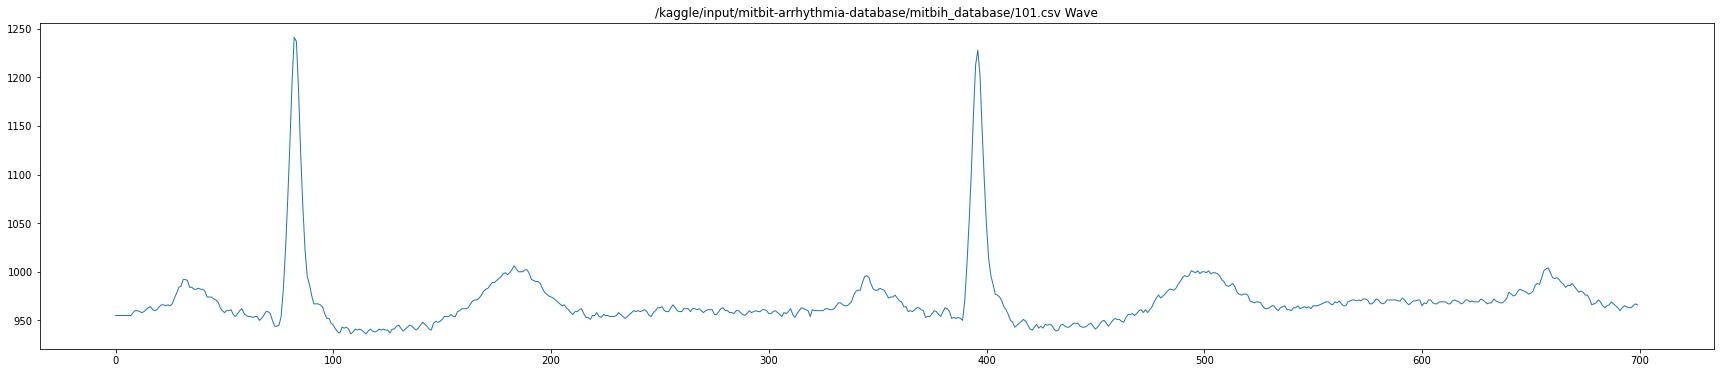

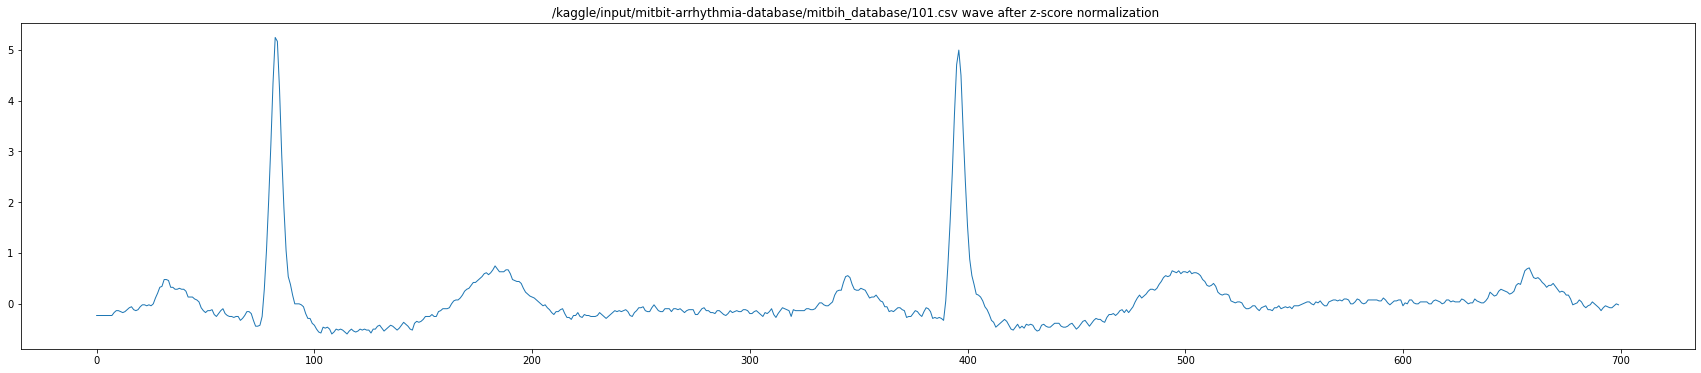

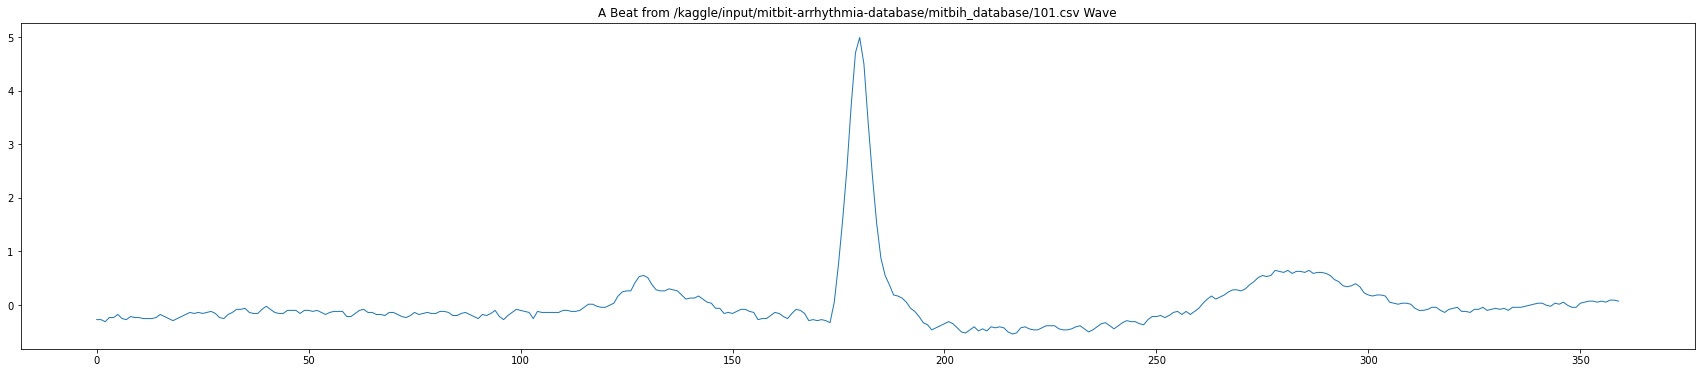

(100012, 360) (100012,)


In [11]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.grid(None)
        plt.show()
        
    #signals = butter_lowpass_filter(signals, 3.667, 30.0, order=6)
   # signals=denoise(signals)
    # Plot an example to the signals
    #if r is 1:
        # Plot each patient's signal
     #   plt.title(records[1] + " wave after denoised")
      #  plt.plot(signals[0:700])
       # plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.grid(None)
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
#                 if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
#                     pass
#                 else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.grid(None)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape

print(np.shape(X), np.shape(y))


In [12]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(100012, 361)


In [ ]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')

In [17]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
# df_5=X_train_df[X_train_df[X_train_df.shape[1]-1]==5]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()

In [22]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [23]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [24]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [25]:
# Instanciate an empty model
model = Sequential()

# Adding a Convolution Layer C1
# Input shape = N = (360 x 1)
# No. of filters  = 16
# Filter size = f = (13 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 360-13+2*6 +1 = 360
# No. of parameters between input layer and C1 = (13*1 + 1)*16 = 224
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))


# Adding an Average Pooling Layer S2
# Input shape = N = (360 x 16)
# No. of filters = 16
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (360-3+0+1)/2 = 179
# No. of parameters between C1 and S2 = (1+1)*16 = 32
model.add(AvgPool1D(pool_size=3, strides=2))





# Adding a Convolution Layer C3
# Input shape = N = (179 x 16)
# No. of filters  = 32
# Filter size = f = (15 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 179-15+2*7 +1 = 360
# No. of parameters between input layer and C1 = (15*1 + 1)*32 = 512
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))


# Adding an Average Pooling Layer S4
# Input shape = N = (179 x 32)
# No. of filters = 32
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (179-3+0+1)/2 = 89
# No. of parameters between C1 and S2 = (1+1)*32 = 64
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C5
# Input shape = N = (89 x 32)
# No. of filters  = 64
# Filter size = f = (17 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 89-17+2*8 +1 = 89
# No. of parameters between input layer and C1 = (17*1 + 1)*64 = 1152
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))



# Adding an Average Pooling Layer S6
# Input shape = N = (89 x 64)
# No. of filters = 64
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (89-3+0+1)/2 = 44
# No. of parameters between C1 and S2 = (1+1)*64 = 128
model.add(AvgPool1D(pool_size=3, strides=2))



# Adding a Convolution Layer C7
# Input shape = N = (44 x 64)
# No. of filters  = 128
# Filter size = f = (19 x 1)
# Padding = true
# Strides = S = 1
# Size of each feature map in C1 is (N-f+2P)/S +1 = 44-19+2*9 +1 = 44
# No. of parameters between input layer and C1 = (19*1 + 1)*128 = 2560
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))


# Adding an Average Pooling Layer S8
# Input shape = N = (44 x 128)
# No. of filters = 128
# Filter size = f = (3 x 1)
# Padding = P = 0
# Strides = S = 2
# Size of each feature map in S2 is (N-f+2P+1)/S = (44-3+0+1)/2 = 21
# No. of parameters between C1 and S2 = (1+1)*128 = 256
model.add(AvgPool1D(pool_size=3, strides=2))



# Flattening the layer 
# There would be 128*(21*1) = 2688 neurons
model.add(Flatten())


# Dropout the layer S9
model.add(Dropout(0.5))



# Adding a Dense layer with regularization l2(0.0001)# S10
# No. of inputs = 2688
# No. of outputs = 35
# No. of parameters = 2688 x 35 + 35 = 94115
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Dense layer with regularization l2(0.0001)# S11
# No. of inputs = 35
# No. of outputs = 5
# No. of parameters = 35*5 + 5 = 180
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))



# Adding a Softmax layer S12
# No. of inputs = 5
# No. of outputs = 5
model.add(Softmax())


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 360, 16)           224       
_________________________________________________________________
average_pooling1d (AveragePo (None, 179, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 32)           7712      
_________________________________________________________________
average_pooling1d_1 (Average (None, 89, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 64)            34880     
_________________________________________________________________
average_pooling1d_2 (Average (None, 44, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 44, 128)           1

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [27]:
history = model.fit(train_x, train_y, batch_size=36, epochs=100, verbose=1, validation_data=(test_x, test_y))

Epoch 1/100
556/556 [==============================] - 28s 48ms/step - loss: 0.5665 - accuracy: 0.7910 - val_loss: 0.1350 - val_accuracy: 0.9594
Epoch 2/100
556/556 [==============================] - 26s 46ms/step - loss: 0.1252 - accuracy: 0.9626 - val_loss: 0.0808 - val_accuracy: 0.9800
Epoch 3/100
556/556 [==============================] - 25s 45ms/step - loss: 0.0873 - accuracy: 0.9761 - val_loss: 0.0713 - val_accuracy: 0.9812
Epoch 4/100
556/556 [==============================] - 26s 46ms/step - loss: 0.0746 - accuracy: 0.9790 - val_loss: 0.0641 - val_accuracy: 0.9824
Epoch 5/100
556/556 [==============================] - 26s 46ms/step - loss: 0.0624 - accuracy: 0.9829 - val_loss: 0.0733 - val_accuracy: 0.9834
Epoch 6/100
556/556 [==============================] - 25s 46ms/step - loss: 0.0653 - accuracy: 0.9836 - val_loss: 0.0578 - val_accuracy: 0.9874
Epoch 7/100
556/556 [==============================] - 26s 46ms/step - loss: 0.0507 - accuracy: 0.9884 - val_loss: 0.0523 - val_ac

**Plotting the loss convergence**

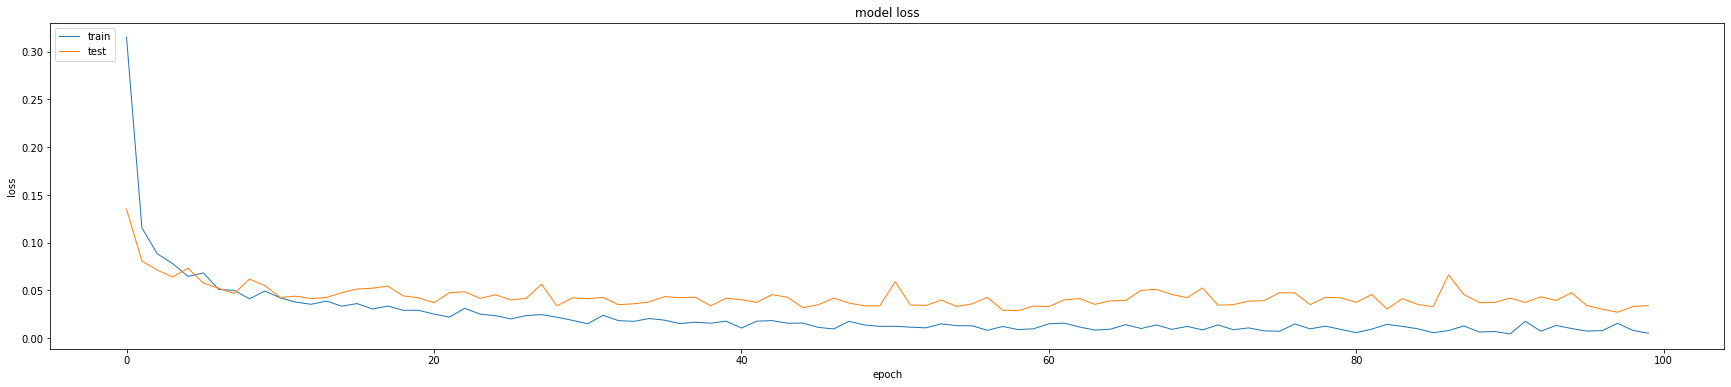

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(None)
plt.show()

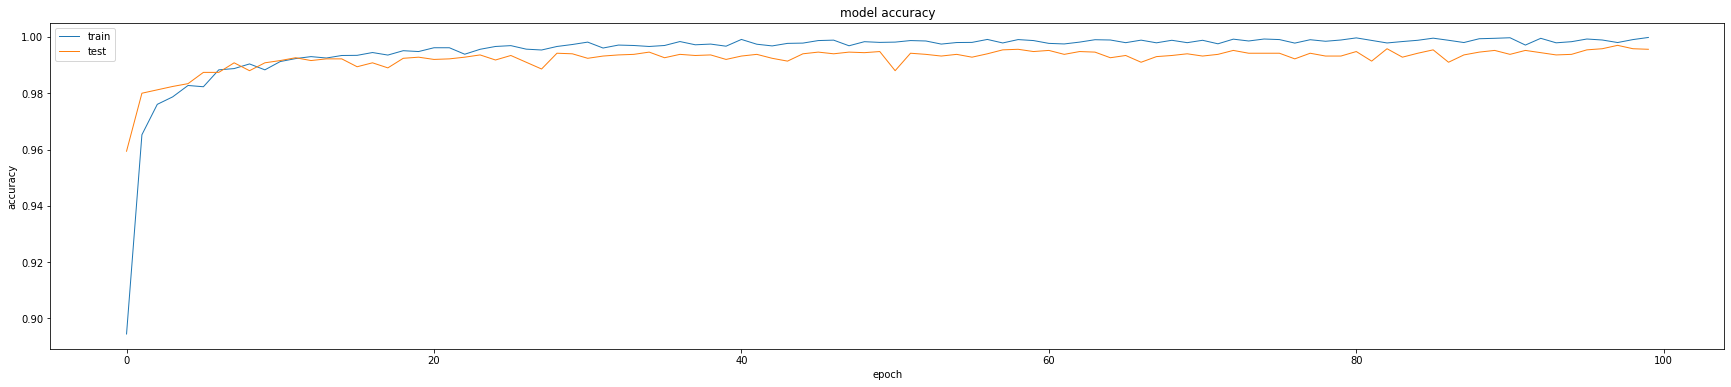

In [29]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(None)
plt.show()

In [30]:
score = model.evaluate(test_x, test_y)
y_pred=model.predict(test_x)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 2s 13ms/step - loss: 0.0342 - accuracy: 0.9956
Test Loss: 0.034205444157123566
Test accuracy: 0.9955999851226807


In [31]:
model.save("modelecg.h5")
print("Saved model to disk")

Saved model to disk


In [32]:
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('modelecg.h5')
# summarize model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 360, 16)           224       
_________________________________________________________________
average_pooling1d (AveragePo (None, 179, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 32)           7712      
_________________________________________________________________
average_pooling1d_1 (Average (None, 89, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 89, 64)            34880     
_________________________________________________________________
average_pooling1d_2 (Average (None, 44, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 44, 128)           1

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plt.grid(None)
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

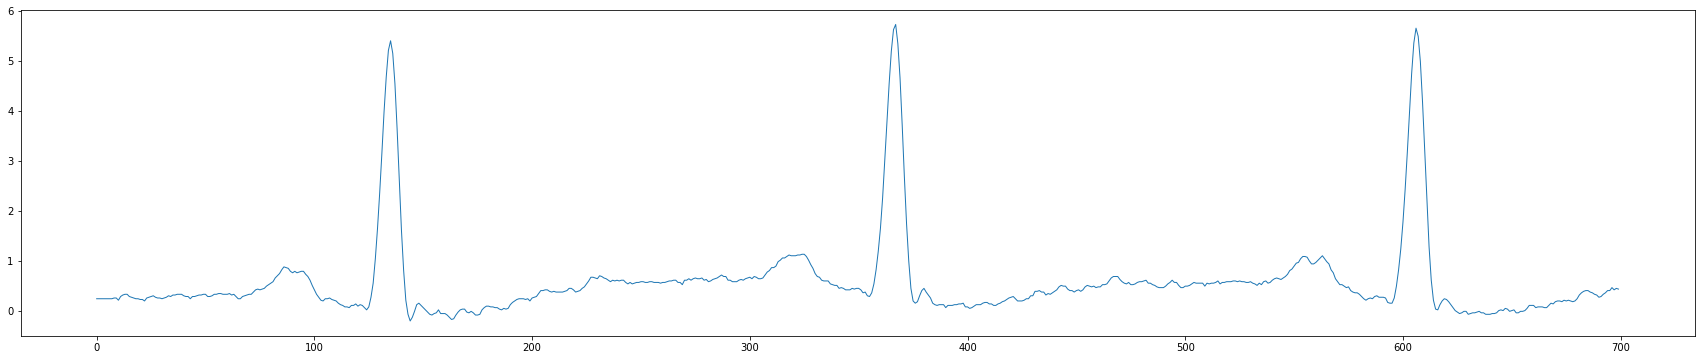

In [35]:
plt.plot(signals[0:700])
plt.grid(None)
plt.show()

(1, 360)
patient values : [[-2.10e-01 -2.10e-01 -2.21e-01 -1.99e-01 -1.99e-01 -1.88e-01 -1.66e-01
  -1.45e-01 -1.56e-01 -1.34e-01 -1.23e-01 -1.23e-01 -1.23e-01 -1.23e-01
  -1.34e-01 -1.45e-01 -1.23e-01 -9.06e-02 -7.98e-02 -4.73e-02 -3.65e-02
  -7.98e-02 -6.89e-02 -6.89e-02 -9.06e-02 -1.12e-01 -7.98e-02 -6.89e-02
  -6.89e-02 -3.65e-02 -6.89e-02 -2.56e-02  2.85e-02 -3.98e-03  6.84e-03
   6.84e-03 -2.56e-02 -4.73e-02 -7.98e-02 -7.98e-02 -3.65e-02 -5.81e-02
  -1.48e-02  6.84e-03  2.85e-02  1.77e-02 -3.98e-03 -3.98e-03 -2.56e-02
  -2.56e-02 -3.98e-03 -1.48e-02 -1.48e-02 -1.48e-02 -1.48e-02 -3.98e-03
   1.77e-02 -3.98e-03  5.01e-02  2.85e-02  6.84e-03  6.84e-03 -1.48e-02
  -3.65e-02 -3.98e-03  1.77e-02 -3.98e-03 -1.48e-02  5.01e-02  2.85e-02
   1.77e-02  3.93e-02  6.84e-03 -3.98e-03 -3.98e-03 -2.56e-02 -3.98e-03
  -1.48e-02  6.84e-03  1.77e-02  2.85e-02  5.01e-02  6.84e-03  2.85e-02
  -3.98e-03  6.84e-03 -3.98e-03 -3.98e-03 -3.98e-03 -2.56e-02  6.84e-03
   3.93e-02  3.93e-02  2.85e-02  2.85e

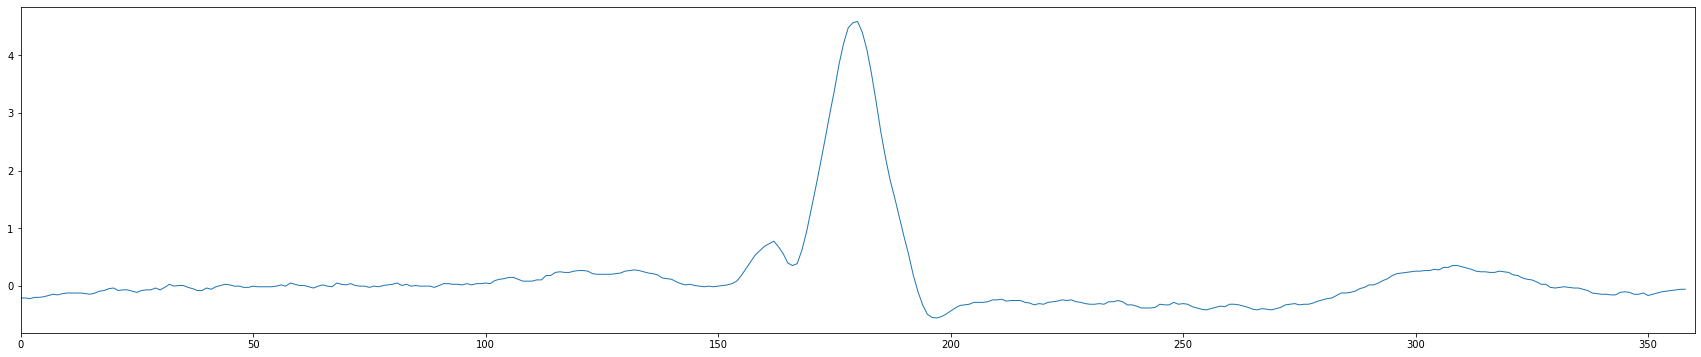

In [37]:
#test = pd.read_csv(r"/input/mitbit-arrhythmia-database/mitbih_database/100.csv", header = None)
test_data=X_train_df.iloc[10000:10001,:test.shape[1]-1].values
print(test_data.shape)

print('patient values :', test_data)
test_data = test_data.reshape(len(test_data), test_data.shape[1],1)
print(test_data.shape)

y_pred=model.predict(test_data)
np.shape(X)
prediction=np.argmax(y_pred,axis=1)
print('\n\nmodel prediction ', prediction)
print('\nactual value', X_train_df.iloc[9:10,:test.shape[1]-1])
# normal 
#plt.plot(X_train_df.iloc[9:10,:test.shape[1]-1])

plt.plot(X_train_df.iloc[10000,:359])
plt.xlim([0, 360])
plt.grid(None)
plt.show()

#color ="green"